In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import trange
import os
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim

from utils import Utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:6')
else:
    device = torch.device('cpu')

In [3]:
'''
Input file
'''
path = './'
file = 'TransferLearningData.csv'

In [4]:
df = pd.read_csv(path+file)
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70835,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.740000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70836,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.575000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70837,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.675000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN
70838,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.980000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,NaN,NaN,NaN,NaN


In [5]:
cols=[]
for col in df.columns:
    if col.startswith('Flag'):
        cols.append(col)

In [6]:
cols

['Flag_AirTemp_C',
 'Flag_Shortwave_Wm2',
 'Flag_Inflow_cms',
 'Flag_WaterTemp_C',
 'Flag_SRP_ugL',
 'Flag_DIN_ugL',
 'Flag_LightAttenuation_Kd',
 'Flag_Chla_ugL']

In [7]:
df[cols].min()

Flag_AirTemp_C              0.0
Flag_Shortwave_Wm2          0.0
Flag_Inflow_cms             0.0
Flag_WaterTemp_C            0.0
Flag_SRP_ugL                0.0
Flag_DIN_ugL                0.0
Flag_LightAttenuation_Kd    0.0
Flag_Chla_ugL               0.0
dtype: float64

In [8]:
df[cols].max()

Flag_AirTemp_C              1.0
Flag_Shortwave_Wm2          1.0
Flag_Inflow_cms             2.0
Flag_WaterTemp_C            1.0
Flag_SRP_ugL                1.0
Flag_DIN_ugL                1.0
Flag_LightAttenuation_Kd    1.0
Flag_Chla_ugL               1.0
dtype: float64

In [9]:
df['Flag_Inflow_cms'].unique()
'''
here, 2 represents no measurement at all
'''

'\nhere, 2 represents no measurement at all\n'

### SANITY CHECK

In [10]:
for lake in df.Lake.unique():
    if not df[df['Lake']==lake].DataType.nunique() == 1:
        print(f'Lake = {lake} has multiple datatype')
    if not df[df['Lake']==lake].Site.nunique() == 1:
        print(f'Lake = {lake} has multiple Sites')
    if not df[df['Lake']==lake].Depth_m.nunique() == 1:
        print(f'Lake = {lake} has multiple Depth_m')

Lake = FCR has multiple datatype


In [11]:
df[df['Lake']=='FCR'].DataType.unique()

array(['observed', 'modeled'], dtype=object)

In [12]:
cols_to_exclude_from_features = ["Lake","Site","Depth_m","DataType","ModelRunType"]
features_col = df.columns.difference(cols_to_exclude_from_features)
features_col = [feat for feat in features_col if not 'flag' in feat.lower()]
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'DateTime',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [17]:
df = df.dropna(subset=features_col).reset_index(drop='true')
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884000,...,0.913978,4.010,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884000,...,0.913978,4.010,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884000,...,0.913978,4.010,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884000,...,0.913978,4.010,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884000,...,0.913978,4.010,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65108,TOOK,2022-06-28,buoy,0.5,observed,NaN,10.52250,55.355000,0.000000,9.207708,...,0.490385,5.020,0,0,2,0.0,1.0,1.0,1.0,0.0
65109,TOOK,2022-06-29,buoy,0.5,observed,NaN,9.98700,164.930000,0.000000,9.448696,...,0.459459,2.025,0,0,2,0.0,1.0,1.0,1.0,0.0
65110,TOOK,2022-06-30,buoy,0.5,observed,NaN,15.41745,145.745000,0.000000,11.911522,...,0.432203,2.890,0,0,2,0.0,1.0,1.0,1.0,0.0
65111,TOOK,2022-07-01,buoy,0.5,observed,NaN,18.67355,136.620000,0.000000,13.435625,...,0.408000,2.605,0,1,2,0.0,1.0,1.0,1.0,0.0


In [14]:
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

### DATA VISUALIZATION

In [15]:
def get_lake_specific_dataframe(df, lake, modeling):
    dz = df.copy(deep=True)
    dz = dz[dz['Lake']==lake]
    if modeling:
        dz = dz[dz['DataType']=='modeled'].reset_index(drop='true')
    else:
        dz = dz[dz['DataType']=='observed'].reset_index(drop='true')

    if len(dz.DateTime[0])>10:
        dz.DateTime = dz.DateTime.apply(lambda l: datetime.strptime(l, '%Y-%m-%d %H:%M:%S'))
    else:
        dz.DateTime = dz.DateTime.apply(lambda l: datetime.strptime(l, '%Y-%m-%d'))
    dz = dz.reset_index(drop=True)
    return dz

def get_date_range(df):
    date_list = df.DateTime[df.shape[0]-1]-df.DateTime[0]
    dx = pd.DataFrame(pd.date_range(df.DateTime[0], periods=date_list.days+1, freq='1d').values, columns=['DateTime']).merge(df, 
                                                                                                                             left_on='DateTime', right_on='DateTime', how='left')
    return dx

def plot(dx, lake, modeling):
    x_ax = dx.DateTime.values
    y_ax = dx.Chla_ugL.values
    x_ax = [a.__str__().split('T')[0] for a in x_ax]
    fig,ax = plt.subplots()
    ax.grid(visible=True, alpha=0.2)
    ax.plot(x_ax, y_ax, linestyle='--', label=lake+"_"+modeling)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Chlorophyll')
    
    if len(x_ax)>1000 and len(x_ax)<2000:
        every_nth = 40
    elif len(x_ax) > 2000:
        every_nth = 50
    else:
        every_nth = 20
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.set_xticklabels(x_ax, rotation=90)
    plt.legend()
    plt.show()

### ITERATING FOR ALL LAKES

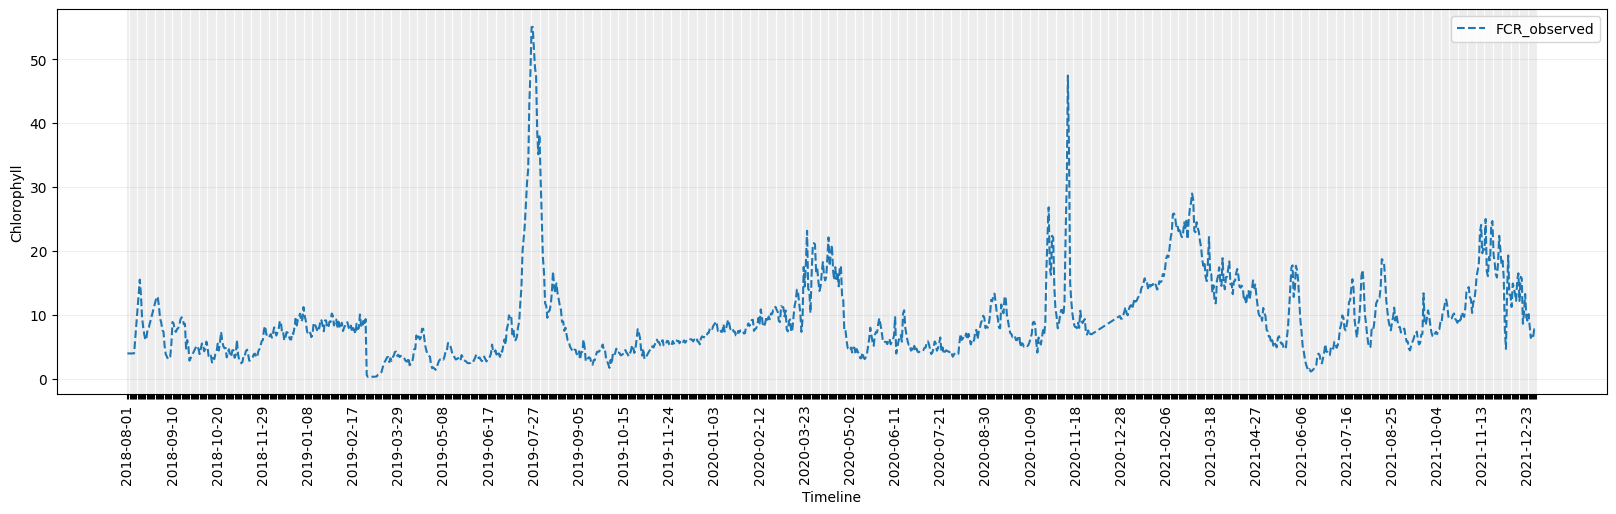

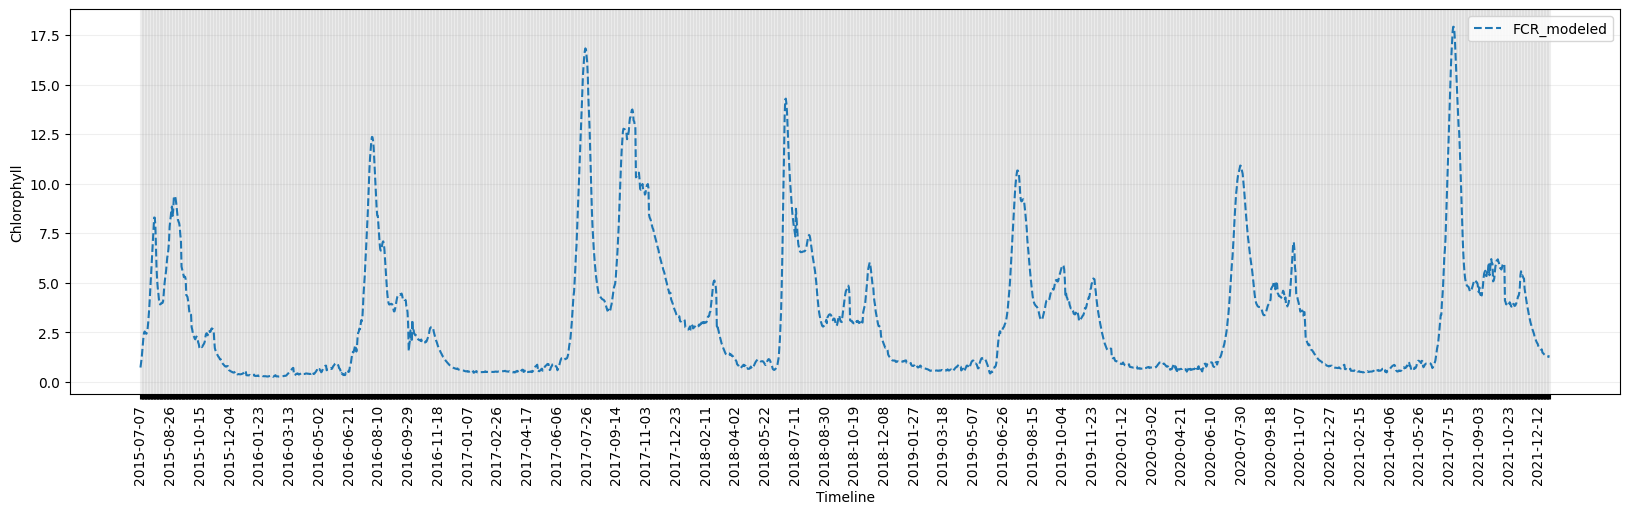

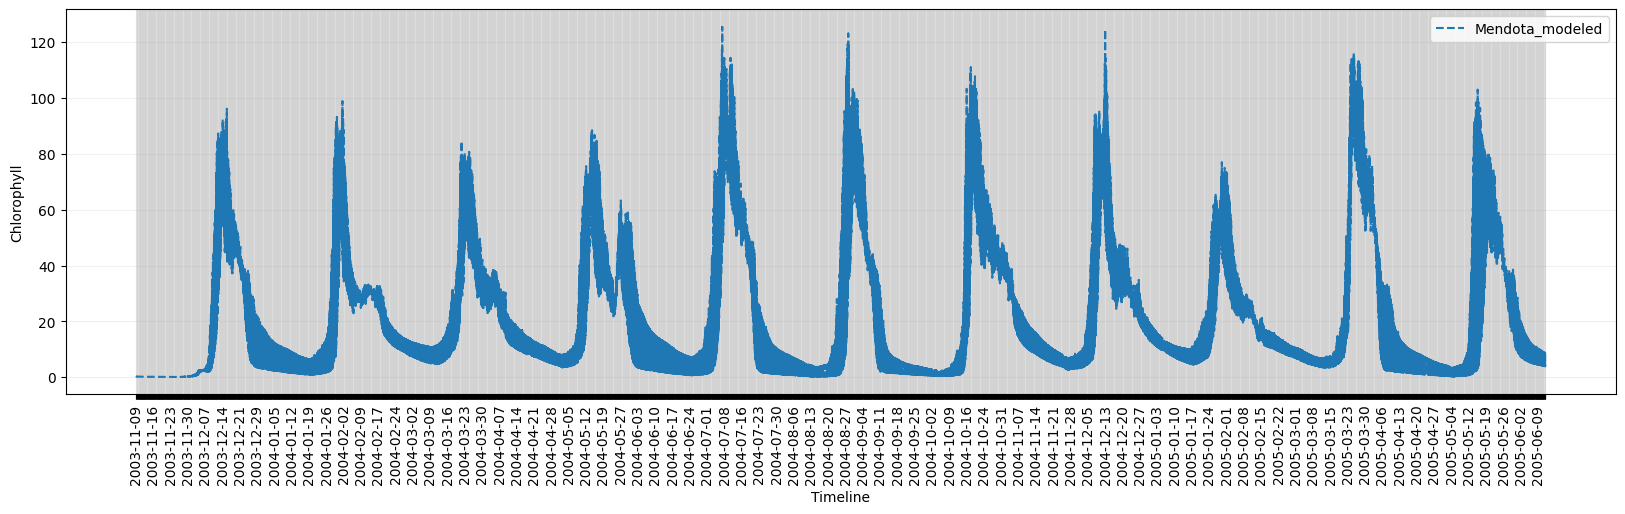

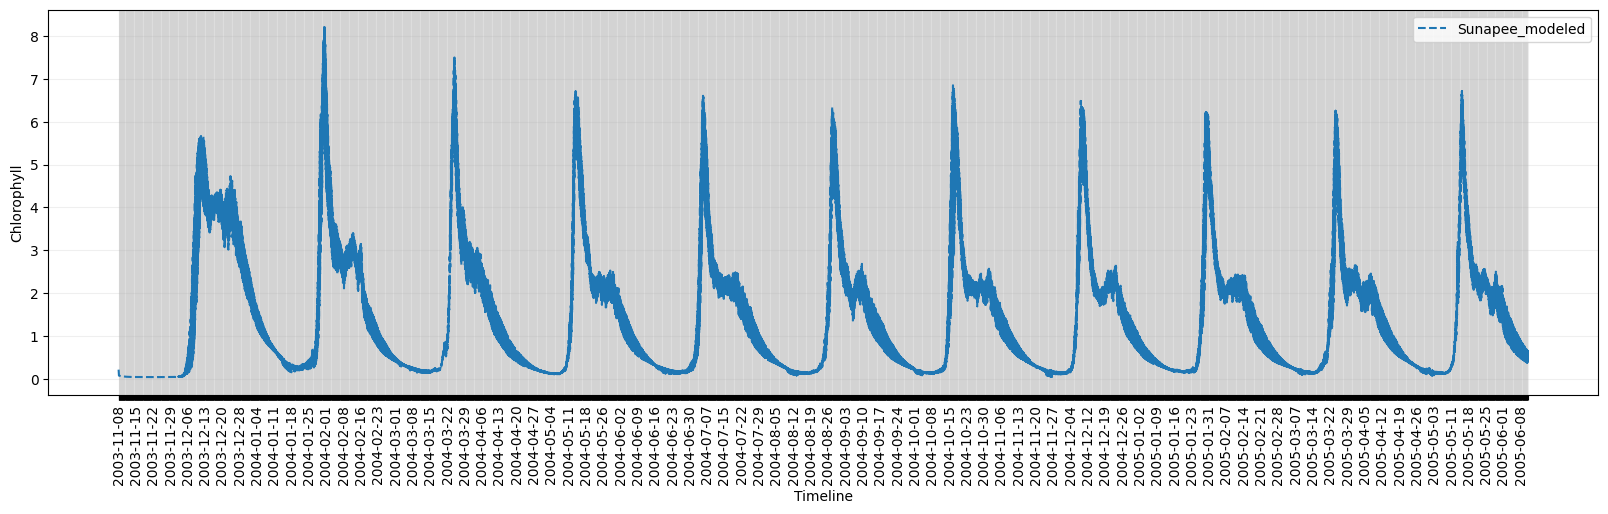

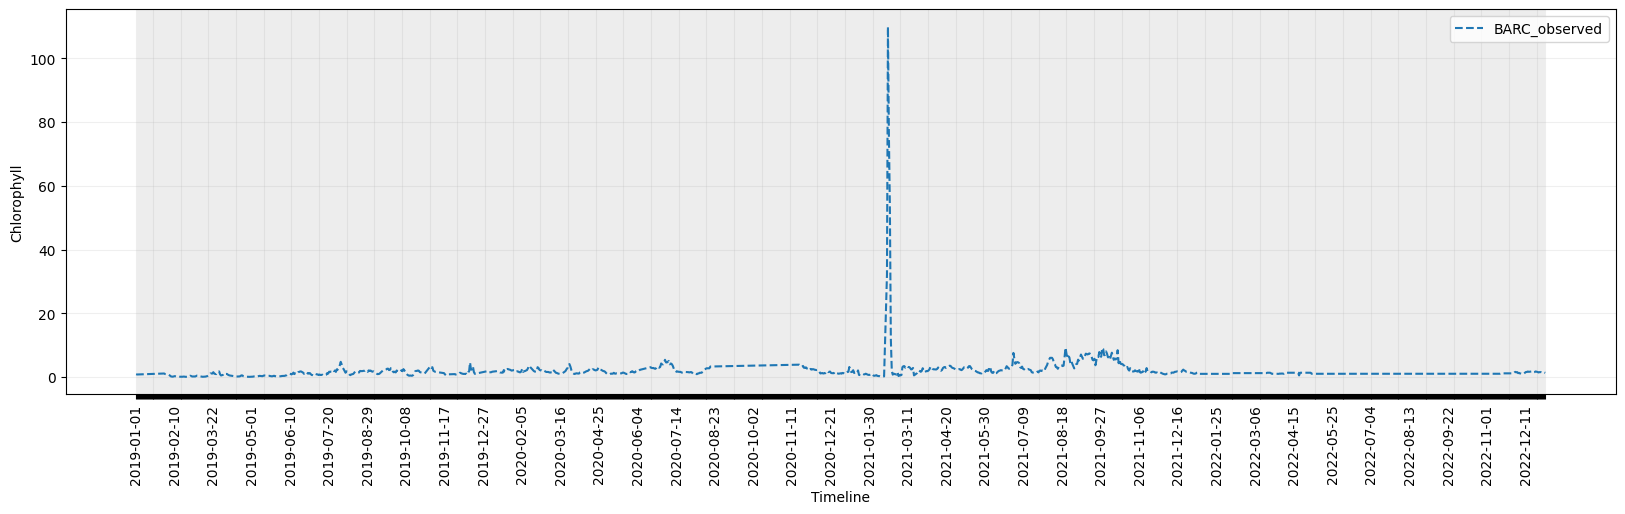

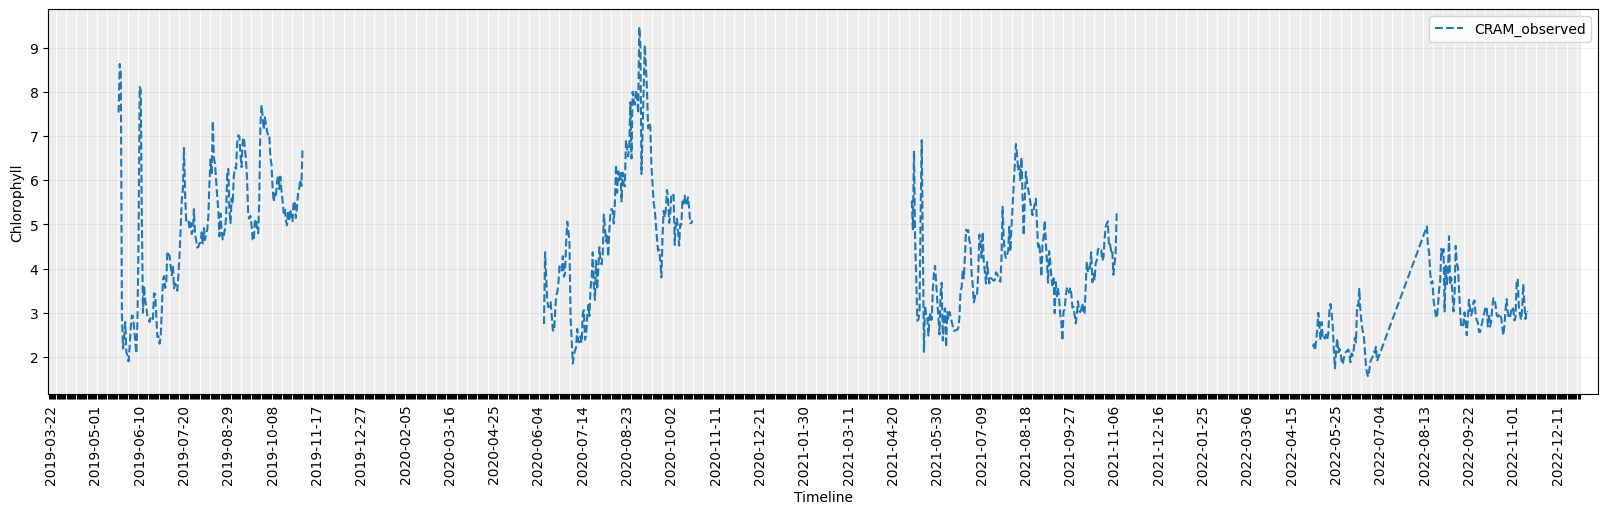

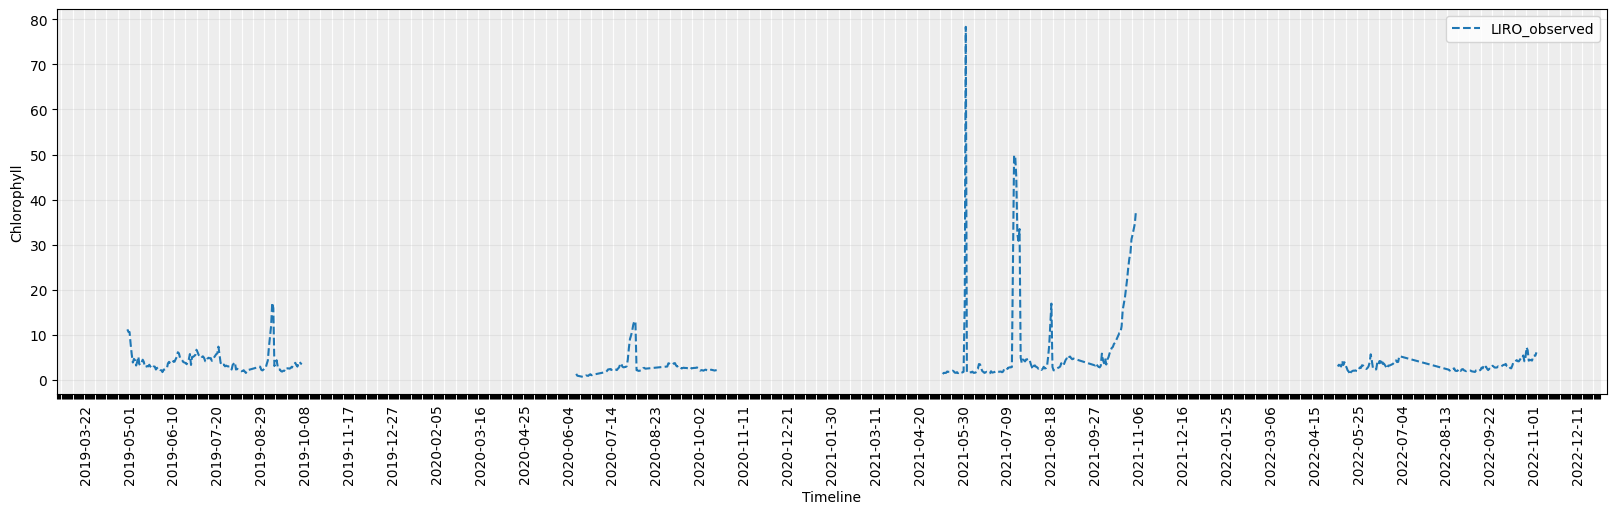

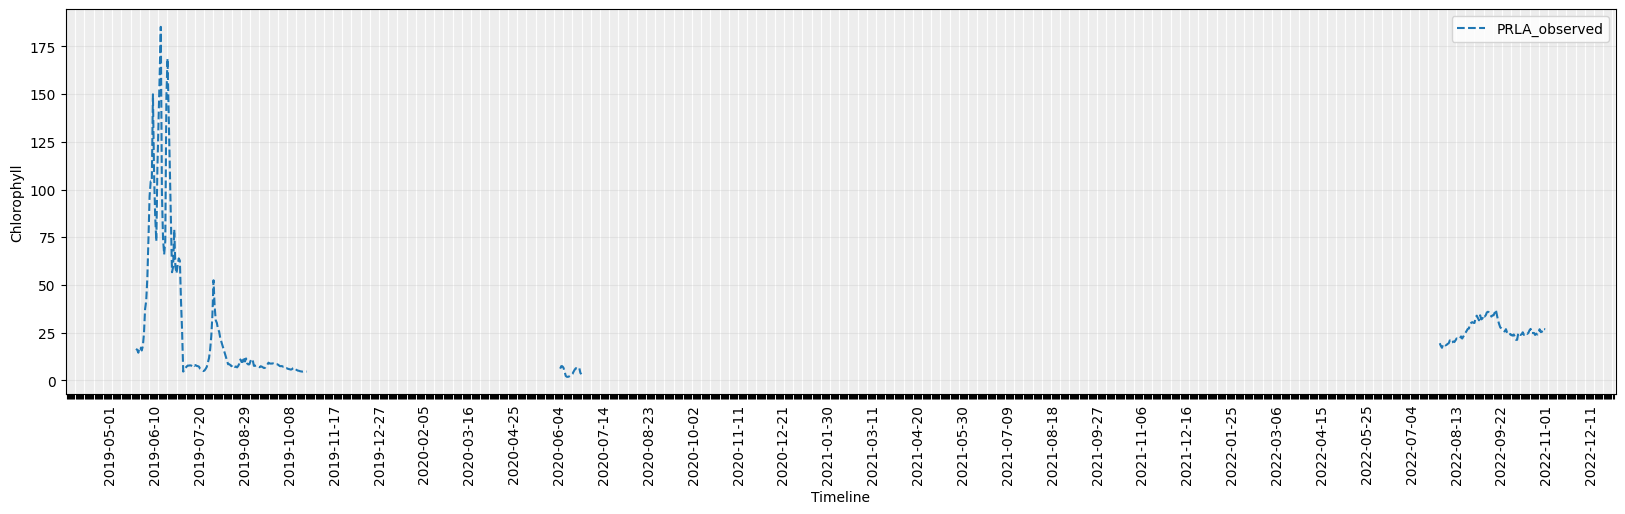

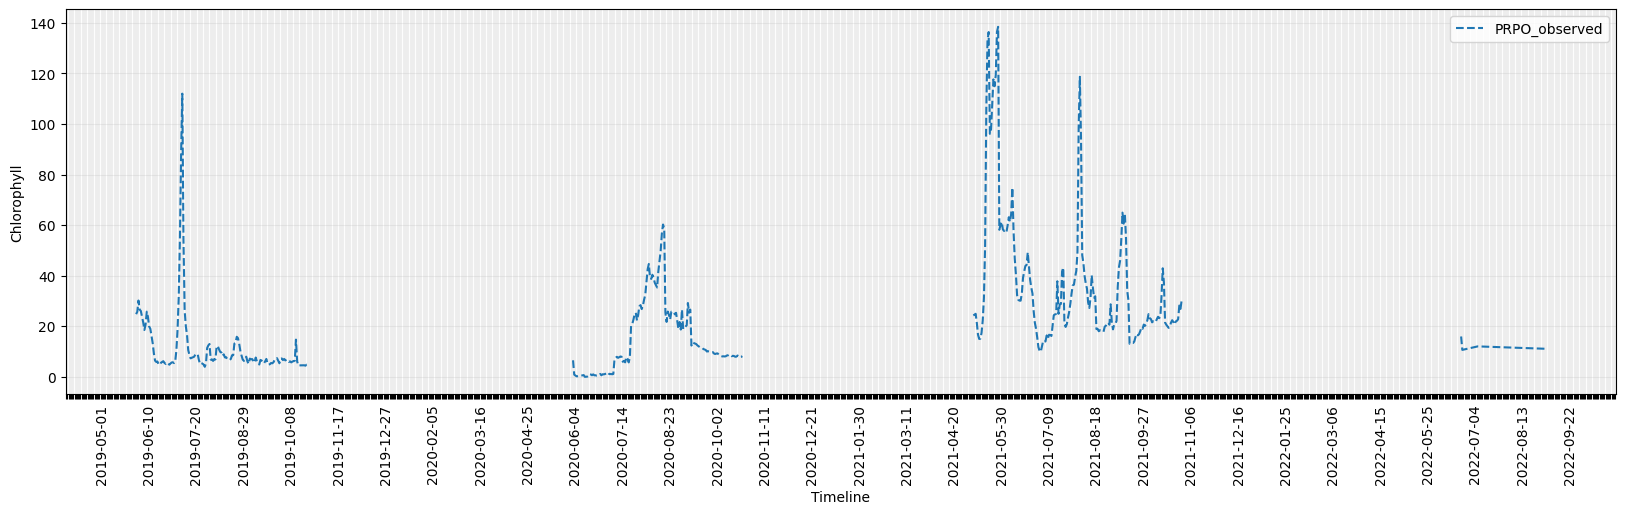

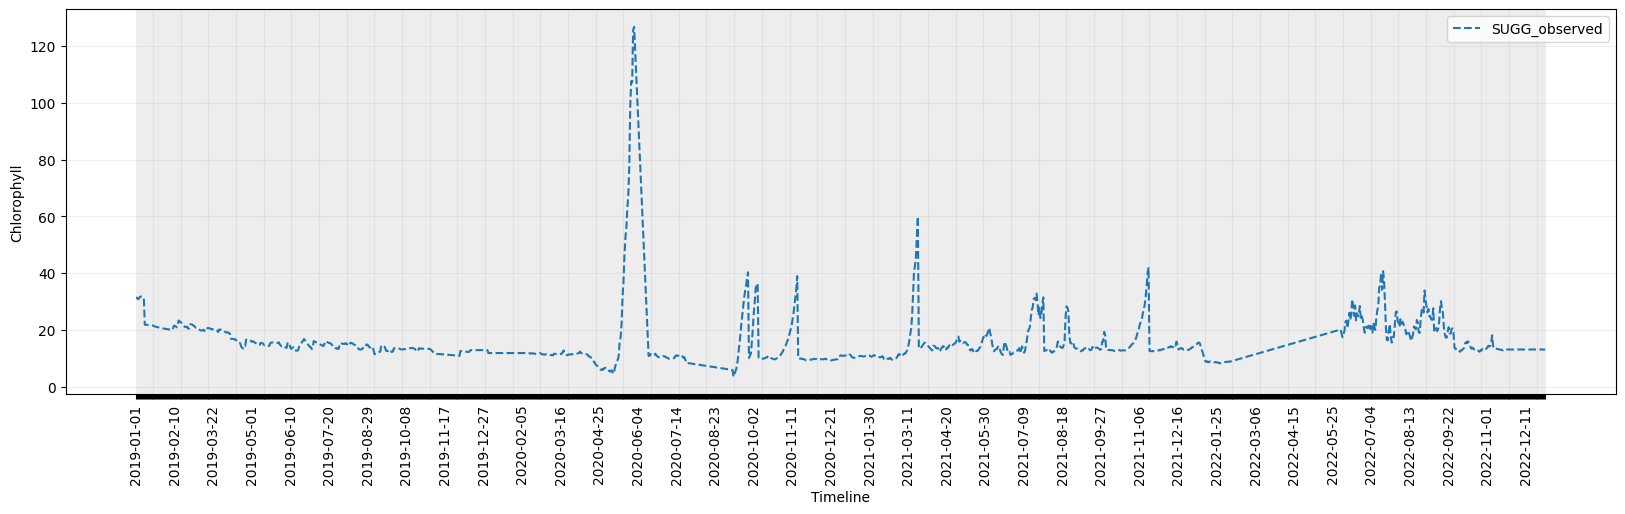

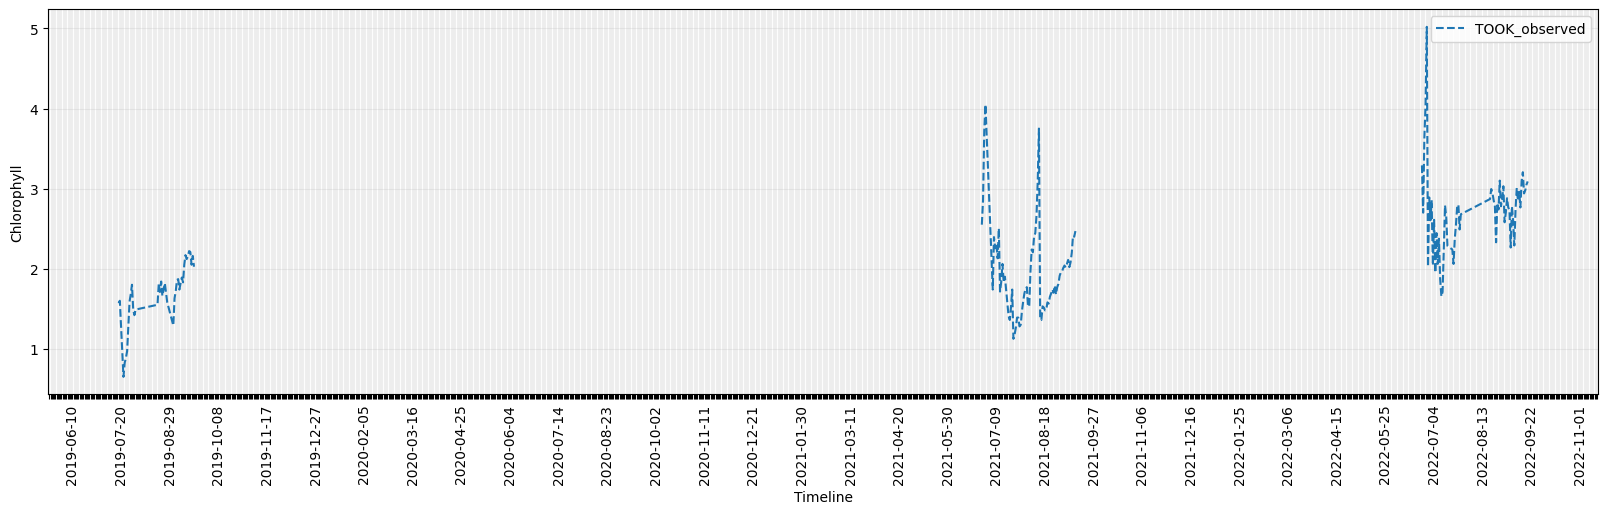

In [16]:
'''
Without performing dropna on df
'''
for lake in df.Lake.unique():

    for modeltype in df[df['Lake']==lake].DataType.unique():
        if modeltype=='observed':
            modeling=False
        else:
            modeling=True
        da = get_lake_specific_dataframe(df, lake, modeling)
        db = get_date_range(da)
        plot(db, lake, modeltype)

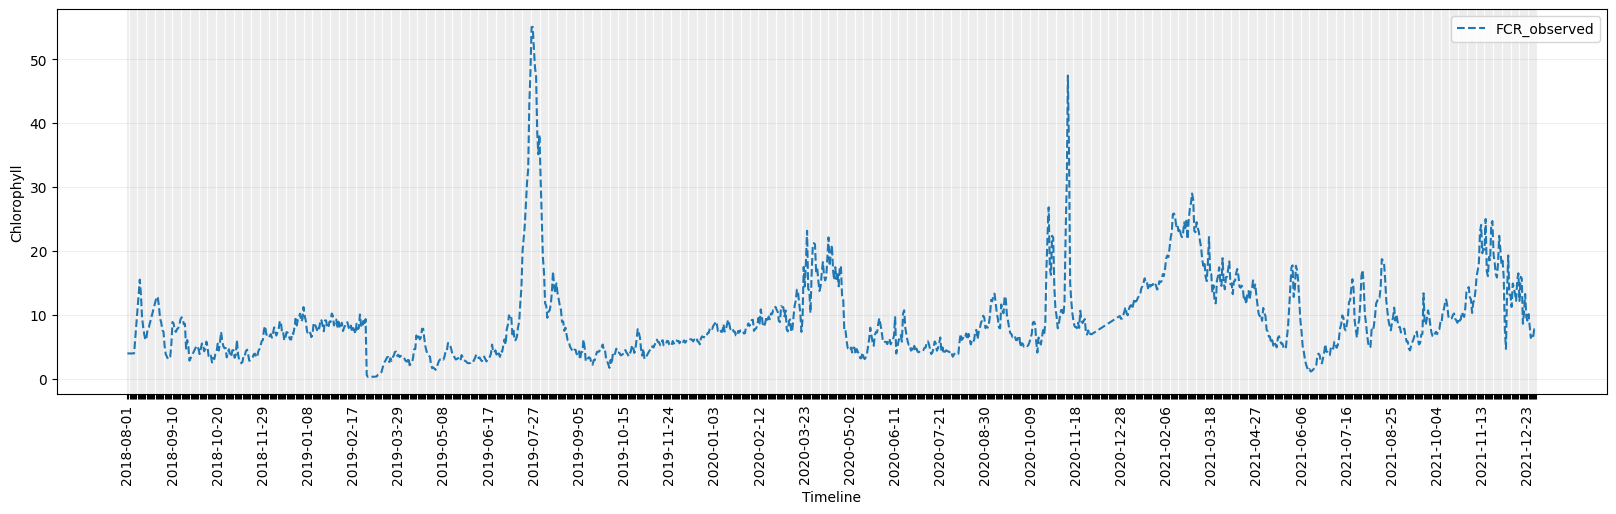

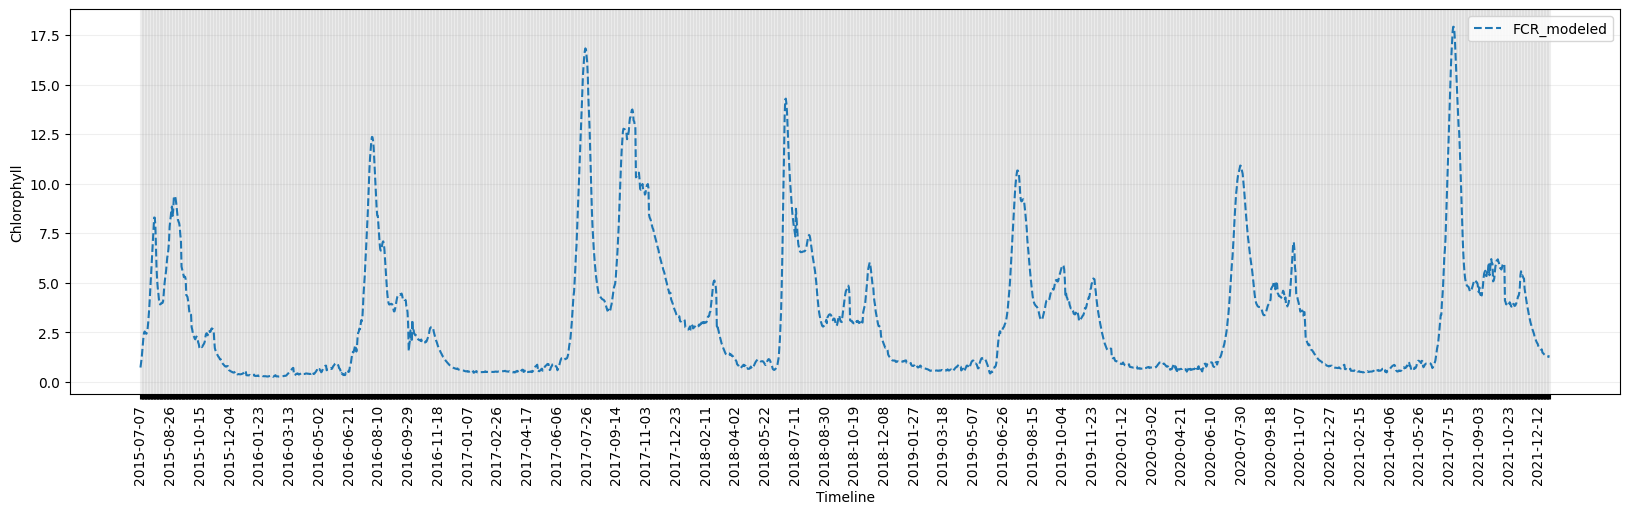

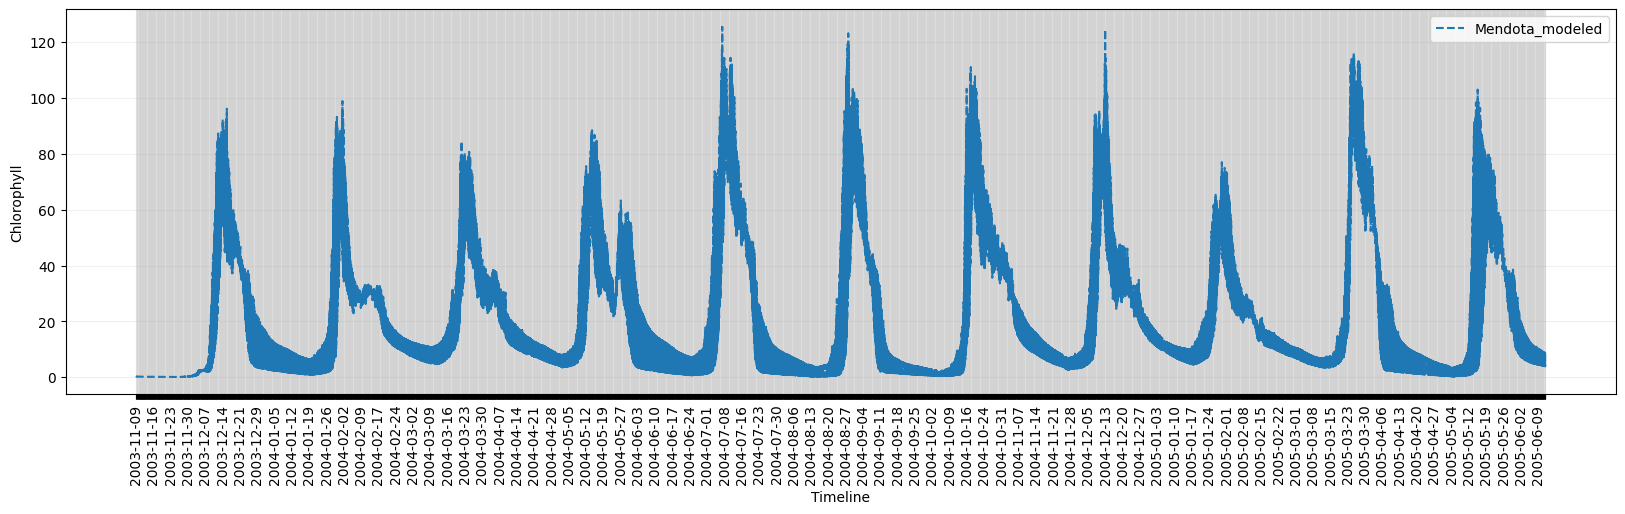

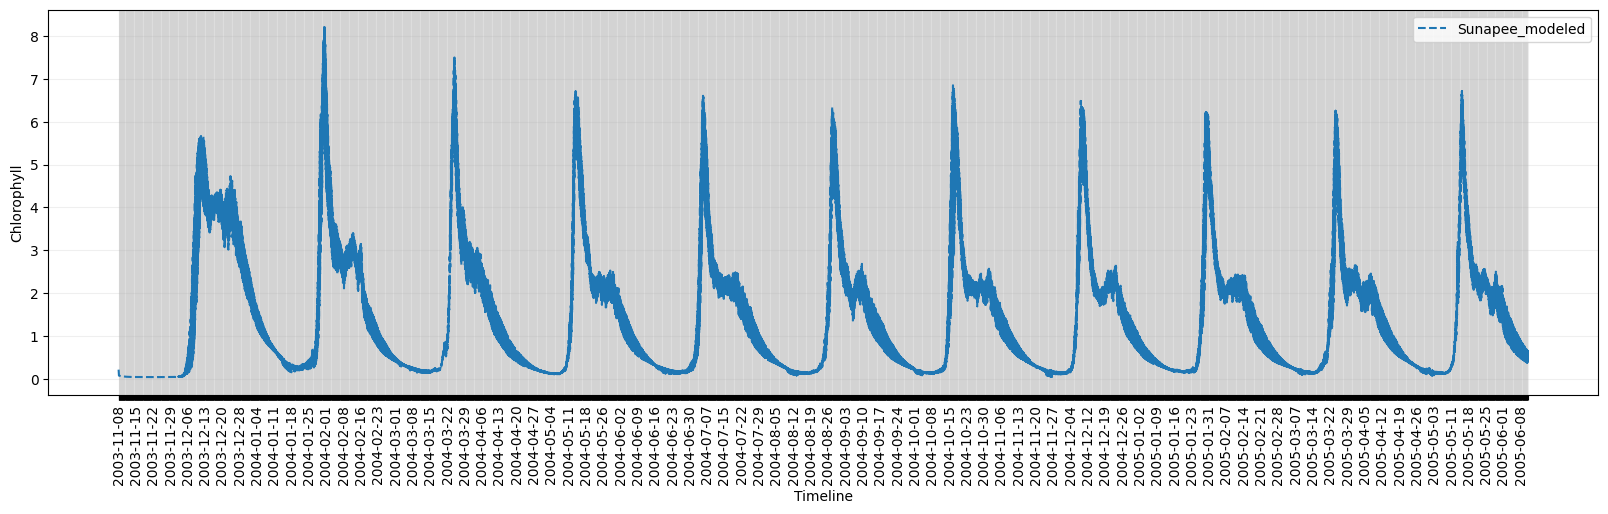

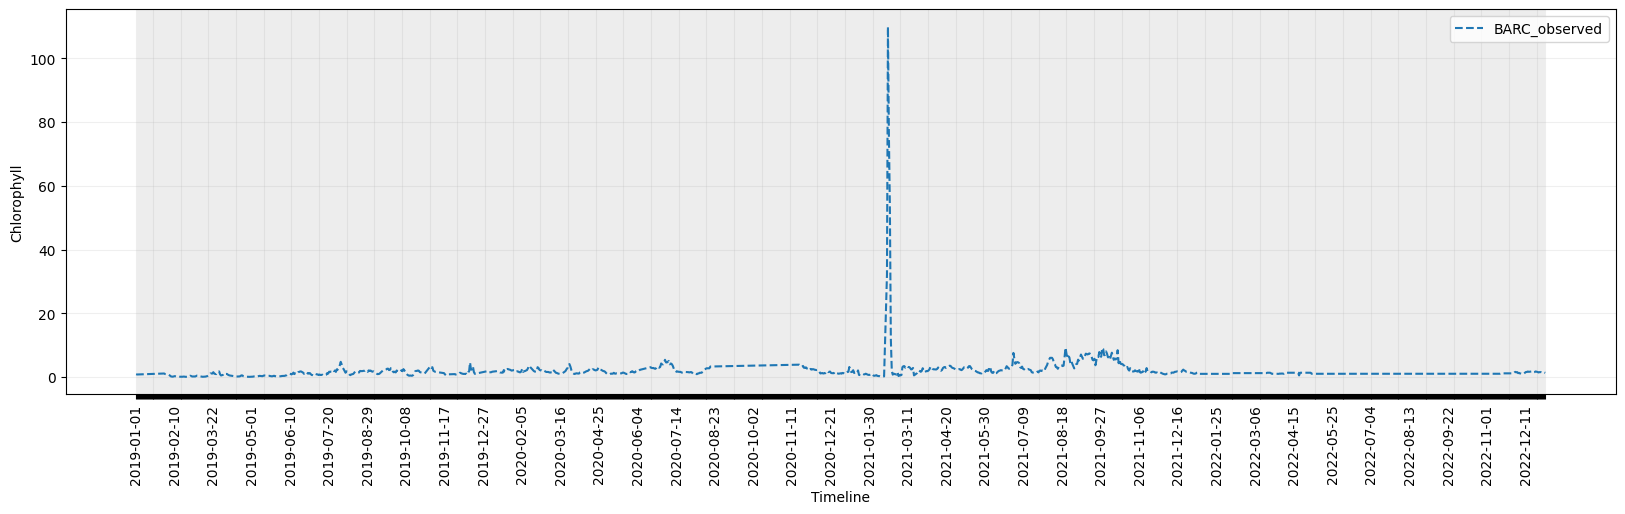

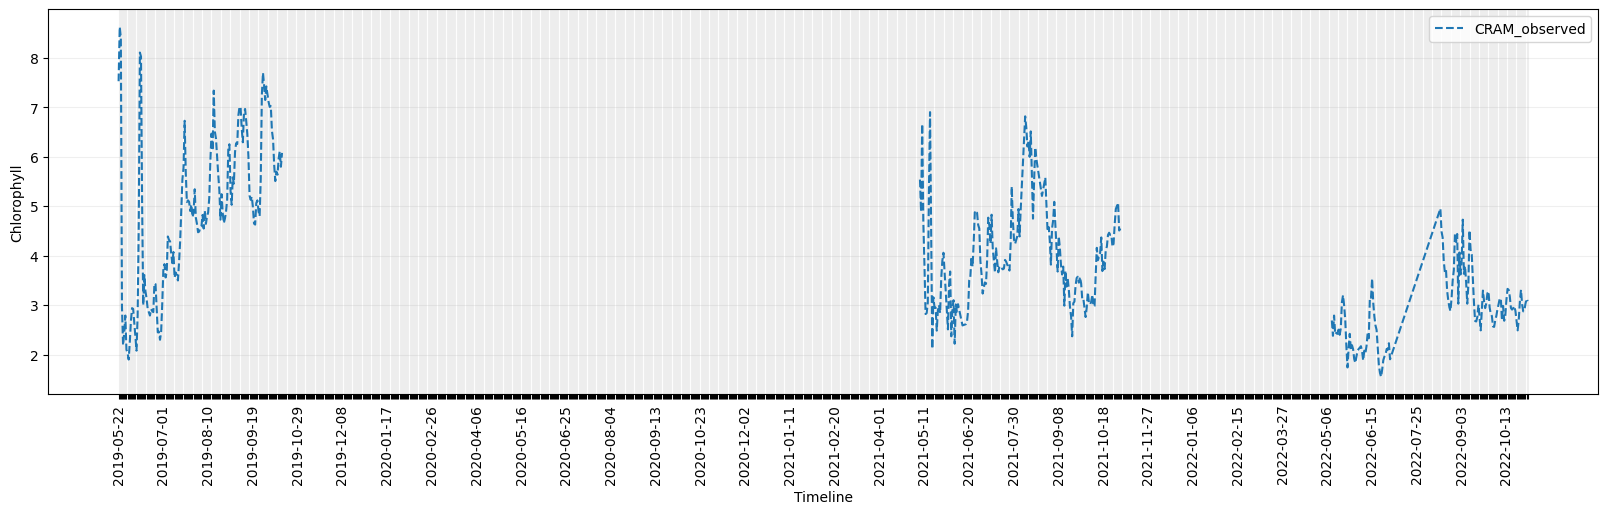

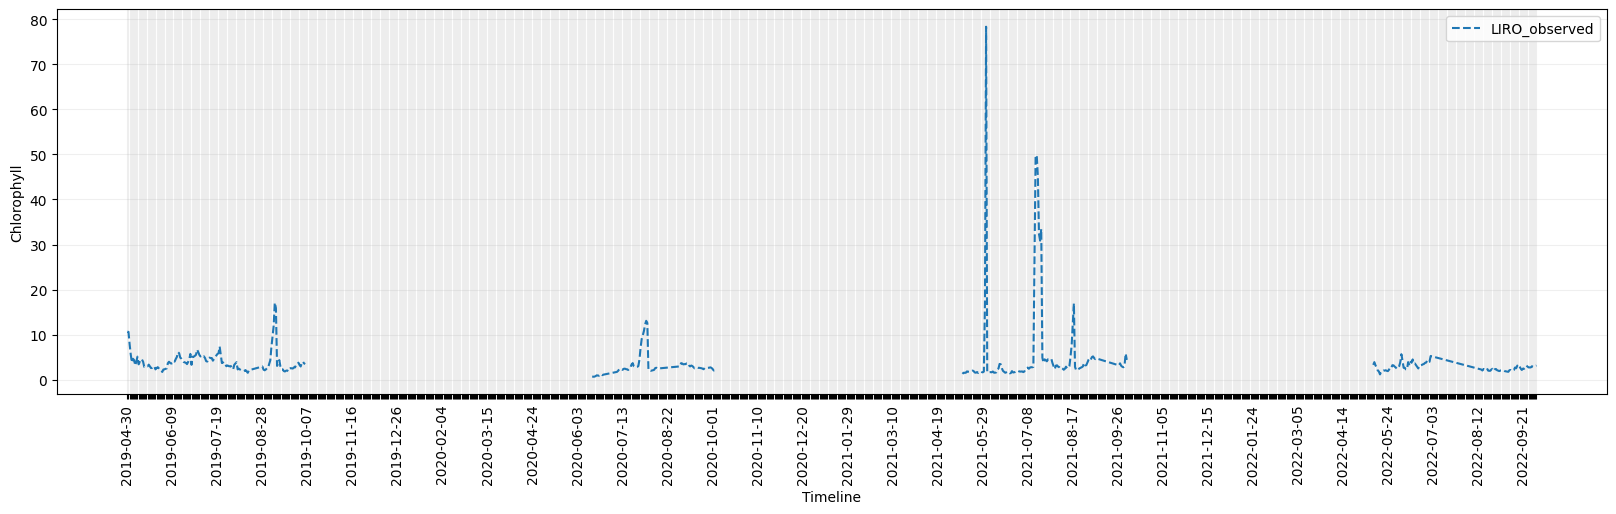

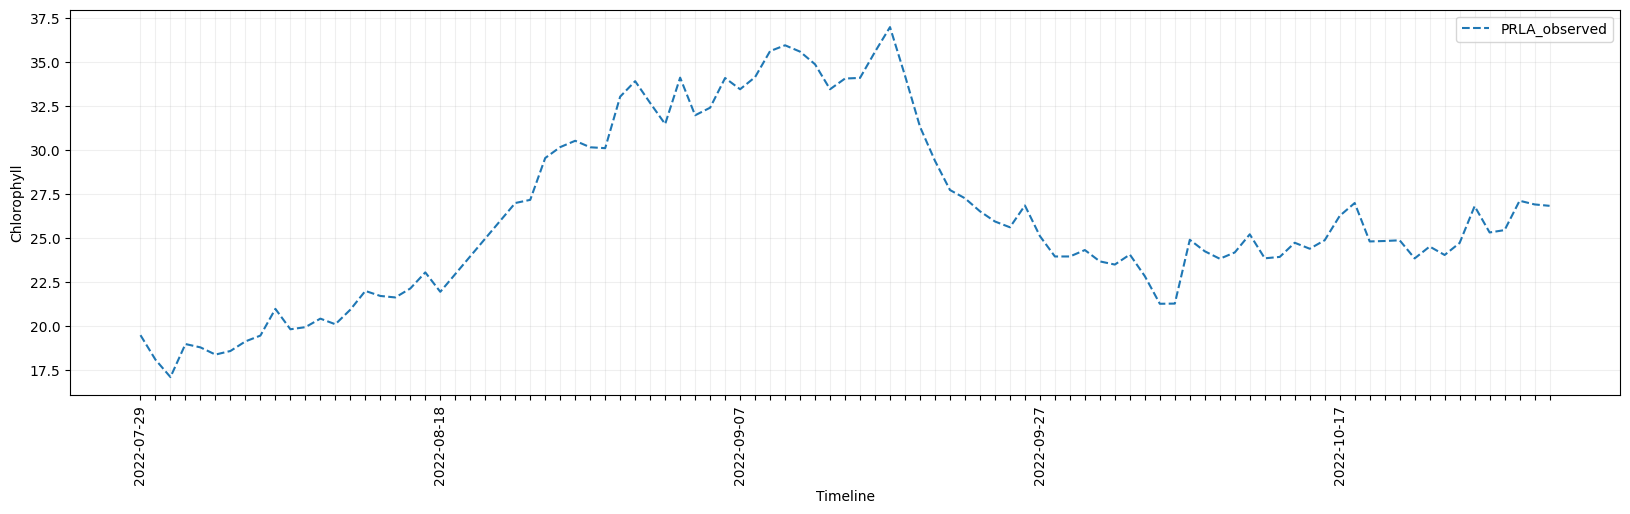

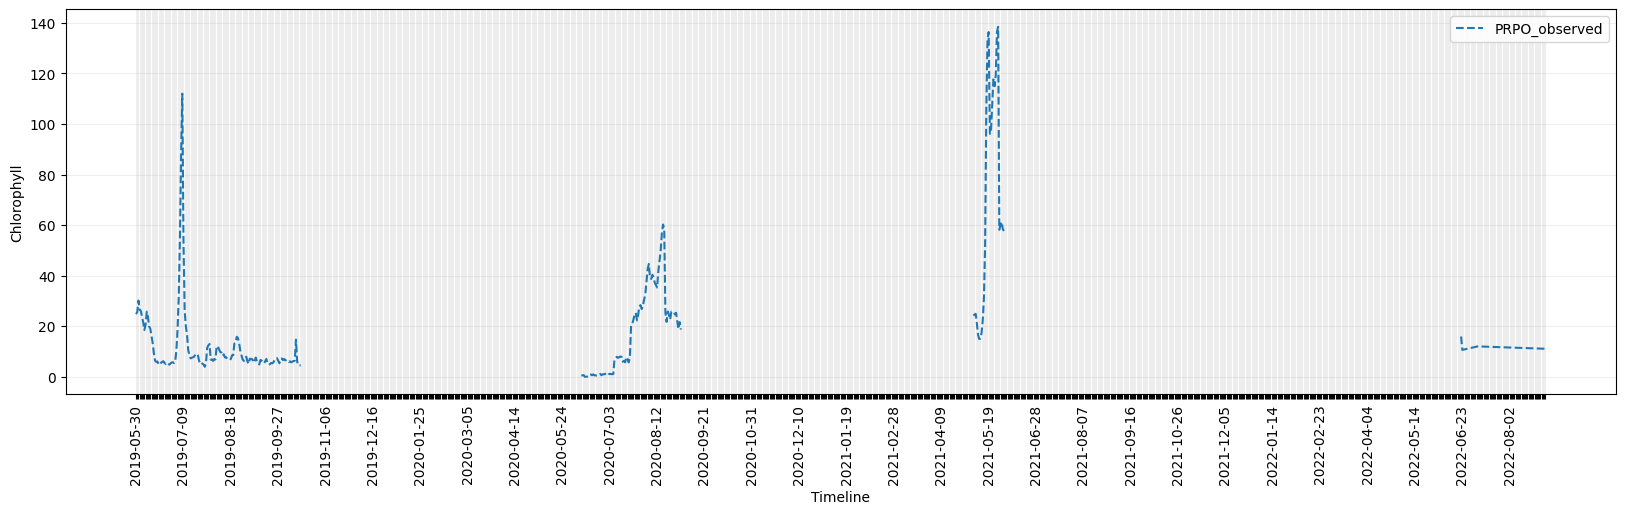

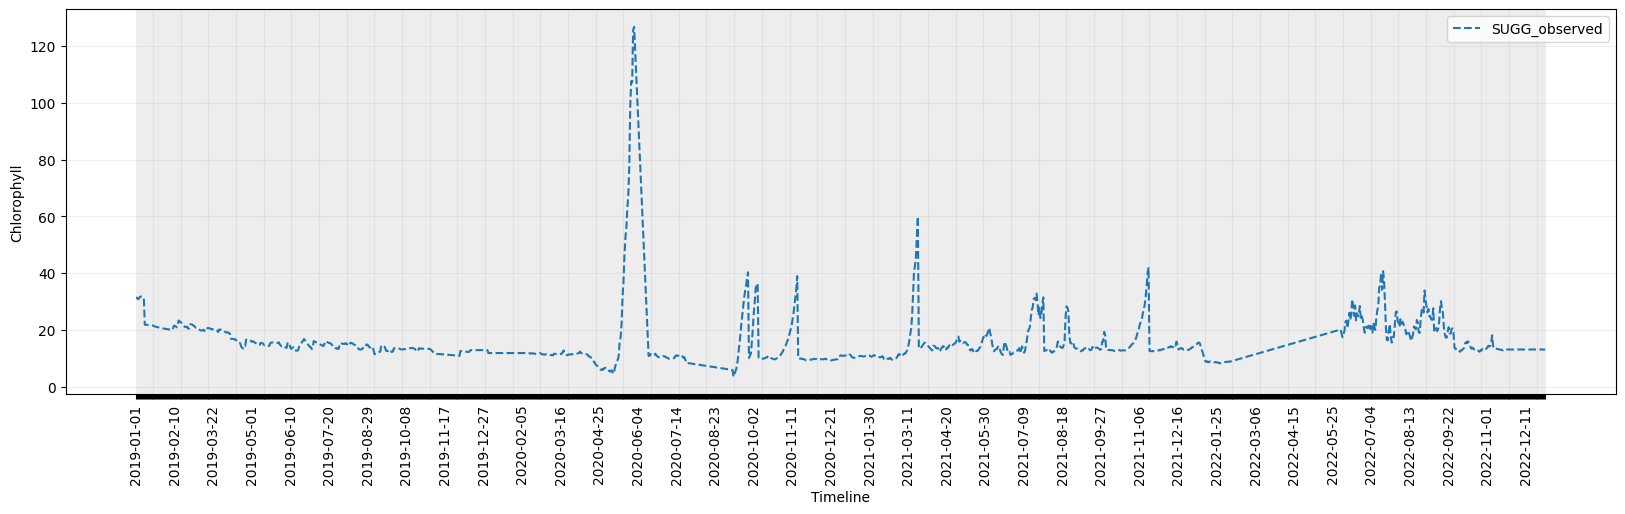

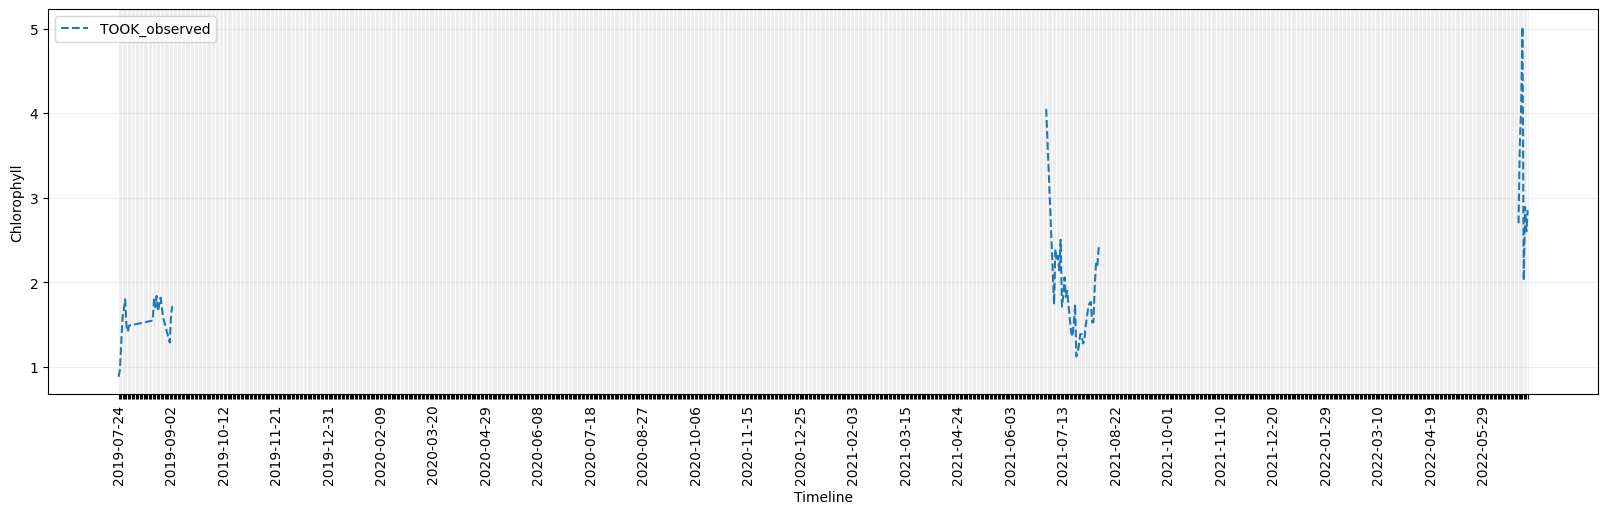

In [18]:
'''
Performing dropna
'''
for lake in df.Lake.unique():

    for modeltype in df[df['Lake']==lake].DataType.unique():
        if modeltype=='observed':
            modeling=False
        else:
            modeling=True
        da = get_lake_specific_dataframe(df, lake, modeling)
        db = get_date_range(da)
        plot(db, lake, modeltype)

### MODELING